**General Remarks**:
<div class="alert alert-danger">
This notebook deals with Hidden Markov Models (HMMs), which will not be covered in the lecture before the 11th of January 2022. If you would like to start early anyway, we recommend reading chapter 17 of Murphy's book 'Machine Learning: A Probabilistic Perspective.'
</div>

Before you start with this problem, study the inference chapter in Slide Deck (SD) 6a.
- Internalize the filtering, prediction, smoothing, and decoding algorithms until you feel confident you can implement them yourself. Only then start working on this problem; otherwise, you will waste a lot of time.

And as always:
- Read the `Instructions` notebook
- Do not delete or add cells.
- Store your results into the corresponding result variables or implement the provided functions.
- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.

In [1]:
import numpy as np
from utils import plot_states, get_weather_example, HMM

### Inference in HMMs

In this assignment, we will implement some of the common inference algorithms for Hidden Markov Models, using the following data structure to store the distribution tables:

In [2]:
import inspect
print(inspect.getsource(HMM))

class HMM:
    def __init__(self, pi: np.ndarray, A: np.ndarray, B: np.ndarray):
        """
        Datastructure that holds the probability tables for
        a discrete observation HMM having N possible states
        and M possible observations.

        :param pi: Initial probabilities (vector of size N)
        :param A: Transition probabilities (matrix of size NxN)
        :param B: Observation probabilities (matrix of size MxN)
        """
        num_states = len(pi)
        assert pi.shape == (num_states,)
        assert A.shape == (num_states, num_states)
        assert np.allclose(A.sum(axis=1), 1)
        assert B.shape[1] == num_states
        assert np.allclose(B.sum(axis=0), 1)
        
        self.num_states = num_states
        self.pi = pi
        self.A = A
        self.B = B



Each `HMM` object holds four member variables (SD 6a., p. 9):
- `num_states` is the number of states the hidden variable can take $\mid S \mid$.
- `pi` represents the inital state distribution model $P(S^{(0)})$.
- `A` gives the state transition probabilities $P(S^{(t+1)} \mid S^{(t)})$ where $\mathbf{A} = \{a_{ij}\} = \{P(s_j^{(t+1)} \mid s_i^{t})\}$. That means, each row in $\mathbf{A}$ represents a probability distribution over the next states given the current state (SD 6a, p. 10).
- `B`gives the observation probabilities $P(O^{(t)} \mid S^{(t)})$ where $\mathbf{B} = \{b_{ij}\} = \{b_j(o_i)\} = \{P(o_i\mid s_j)\}$. That means, each column in $\mathbf{B}$ is a probability distribution over observations given the current state (SD 6a, p. 11).


### Filtering

<div class="alert alert-warning">

Implement the forward algorithm for filtering! (4 points)

</div>

`forward` takes two parameters:
 - `hmm` is a HMM object which holds $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\Pi}$.
 - `observations` is a 1-D NumPy array representing the observed sequence.
 
`forward` returns
- a NumPy array of shape `(len(observations) + 1, hmm.num_states)`. Row $t$ represent the filtering distribution $\mathsf{f}^{(1:t)} = P(S^{(t)} \mid \mathbf{o}^{(1:t)})$, for $t$ from `0` to `len(observations)`.

*Hints*:
- $\mathsf{f}^{(1:0)}$ is the intial state distribution $\mathbf{\Pi}$.
- Compute the forward message at time $t$ recursively from the previous forward message (SD 6a, p. 16):

  $$P(S^{(t+1)} \mid \mathbf{o}^{(1:t+1)}) = \mathsf{f}^{(1:t+1)} = \frac{1}{Z} \cdot \mathbf{B}[o^{(t+1)}] \circ \mathbf{A}^T \mathbf{f}^{(1:t)}$$

  $Z$ is the normalization constant, i.e. the sum over the values in the forward message.

- A NumPy array (matrix) `X` can be transposed with `X.T`.
- Use `X * Y` to compute the element-wise (Hadamard) product between two arrays.
- `np.dot(X, y)` (or `X @ y`) can be used to compute the sum-product over the last axis of X and y, where X is a 2-D array, and y is a 1-D array.

In [3]:
def forward(hmm: HMM, observations: np.ndarray):
    """
    Computes the filtering distribution (forward messages) for a given 
    Hidden Markov Model and observations.
    
    :param hmm: HMM datastructure
    :param observations: Numpy array containing the observations

    :return: filtering distribution (each row represents a time step)
    """
    # initialize empty array for the forward messages
    f = np.empty((len(observations) + 1, hmm.num_states))
    
    # YOUR CODE HERE
    f[0] = hmm.pi

    for i in range(1, f.shape[0]):
        f[i] = hmm.B[observations[i - 1]] * (hmm.A.T @ f[i - 1])
        f[i] /= f[i].sum()

    return f

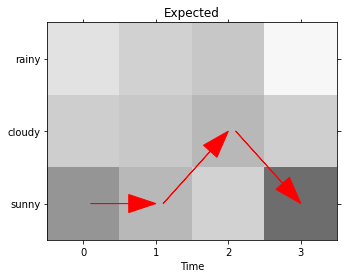

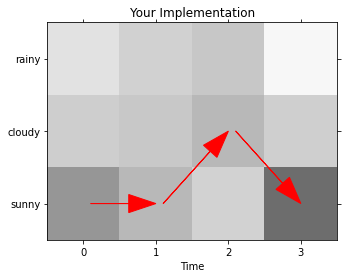

In [4]:
# sanity check using weather example from the lecture slides
expected_f = np.array([
    [0.2, 0.28464419, 0.33090744, 0.06386911],
    [0.3, 0.3258427,  0.38844667, 0.2900097 ],
    [0.5, 0.38951311, 0.28064589, 0.64612119]
]).T # < Note the transposed here >


actual_f = forward(*get_weather_example())

# check shape
assert actual_f.shape == expected_f.shape, f'Shape mismatch, expected {expected_f.shape}, but got {actual_f.shape}.'
assert np.allclose(actual_f.sum(axis=1), np.ones((4,))), f'Proper probability distribution expected. (Entries sum to 1).'

# plot best path
plot_states(expected_f.argmax(axis=1), expected_f, title="Expected", state_names=['rainy', 'cloudy', 'sunny'])
plot_states(actual_f.argmax(axis=1), actual_f, title="Your Implementation",state_names=['rainy', 'cloudy', 'sunny'])

# check values
assert np.allclose(expected_f, actual_f), f'Result mismatch, expected \n{expected_f} \nbut got \n{actual_f}.'

### Prediction

<div class="alert alert-warning">

Implement the forward algorithm for prediction! (4 points)

</div>

`prediction` takes three parameters:
 - `hmm` is a HMM object which holds $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\Pi}$.
 - `observations` is a 1-D NumPy array representing the observed sequence.
 - `steps` is the number of steps to project the hidden state into the future.
 

`prediction` returns
- a NumPy array of shape `(len(observations) + 1 + steps, hmm.num_states)`. The rows represent the distributions:
    - $P(S^{(t)} \mid \mathbf{o}^{(1:t)}) \quad \text{if}  \;  t \in \{0, \ldots, T\}$, and
    - $P(S^{(t)} \mid \mathbf{o}^{(1:T)}) \quad \text{otherwise}$, i.e. for the $s$ prediction steps.

*Hints*:

- Use your `forward` function to initialize the first $t+1$ distributions (we already did this for you):
    $$P(S^{(t)} \mid \mathbf{o}^{(1:t)}) = \mathbf{p}^{(t)} = \mathsf{f}^{(1:t)}$$
    
- After that, compute the forward messages for the $k^{\text{th}}$ prediction step recursively (SD 6a, p. 27):

$$P(S^{(T + k + 1)} \mid \mathbf{o}^{(1:T)}) = \mathbf{p}^{(T+k+1)} = \mathbf{A}^T \mathbf{p}^{(T+k)}$$

- You will need matrix transposition and a matrix-vector product again.

In [5]:
def prediction(hmm: HMM, observations: np.ndarray, steps: int):
    """
    Computes the forward messages and future predictions for a given 
    Hidden Markov Model and observations.
    
    :param hmm: HMM data structure
    :param observations: Numpy array containing the observations

    :return: forward messages and predictions (each row represents a time step)
    """
    # initialize empty array for the forward messages
    p = np.empty((len(observations)+1+steps, hmm.num_states))
    
    # initialize the states for which we have observation
    p[:len(observations)+1] = forward(hmm, observations)
    
    # YOUR CODE HERE
    for s in range(steps):
        p[len(observations) + 1 + s] = hmm.A.T @ p[len(observations) + s]
    
    return p

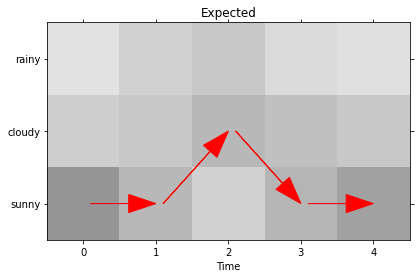

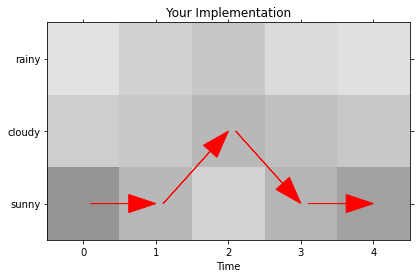

In [6]:
# sanity check using the weather example
expected_f = np.array([
    [0.2, 0.28464419, 0.33090744, 0.2381169, 0.20747555],
    [0.3, 0.3258427,  0.38844667, 0.36040482, 0.32782579],
    [0.5, 0.38951311, 0.28064589, 0.40147828, 0.46469866]
]).T

actual_f = prediction(*get_weather_example(sequence=[2,1]), 2)

# check shape
assert actual_f.shape == expected_f.shape, f'Shape mismatch, expected {expected_f.shape}, but got {actual_f.shape}.'
assert np.allclose(actual_f.sum(axis=1), np.ones((5,))), f'Proper probability distribution expected. (Entries sum to 1).'

# plot best path
plot_states(expected_f.argmax(axis=1), expected_f, title="Expected", state_names=['rainy', 'cloudy', 'sunny'])
plot_states(actual_f.argmax(axis=1), actual_f, title="Your Implementation",state_names=['rainy', 'cloudy', 'sunny'])

# check values
assert np.allclose(expected_f, actual_f), f'Result mismatch, expected \n{expected_f} \nbut got \n{actual_f}.'

# check stationary distribution
assert np.allclose(
    prediction(*get_weather_example(sequence=[2,1]), 16)[-1], 
    np.array([0.181827, 0.27275136, 0.54542164])
)

### Smoothing

<div class="alert alert-warning">

Implement the backward algorithm for smoothing! (4 points)

</div>

`backward` takes two parameters:
 - `hmm` is a HMM object which holds $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\Pi}$.
 - `observations` is a 1-D NumPy array representing the observed sequence.
 
`backward` returns
- a NumPy array of shape `(len(observations) + 1, hmm.num_states)`. The rows in this array represent the  probabilities $\mathsf{b}^{(t+1:T)} = P(\mathbf{o}^{(t+1:T)} \mid S^{(t)})$. <br>**Important:** Rescale these probabilities to avaid arithmetic underflow. Rescale each backward message such that its values sum to one.


*Hints*:
- initialize $\mathsf{b}^{(T+1:T)}$ with  $\frac{\mathbf{1}}{\mid S \mid }$.
- Use our modified formula to compute the normalized backward message at time $t$ recursively given the one at $t+1$:

  $$ P(\mathbf{o}^{(t+1:T)} \mid S^{(t)}) = \mathsf{b}^{(t+1:T)} = \frac{1}{Z} \cdot \mathbf{A}(\mathbf{B}[o^{(t+1)}]^T \circ \mathsf{b}^{(t+2:T)})$$

 $Z$ is the normalization constant, i.e. the sum over the values in the backward message.

- The equation uses transposition to turn row vectors into column vectors. In NumPy, vectors do not have an orientation anyway.
- You will need the Hadamard product and a matrix-vector product again.

In [7]:
def backward(hmm: HMM, observations: np.ndarray):
    """
    Computes the backward messages for a given 
    Hidden Markov Model and observations.
    
    :param hmm: HMM datastructure
    :param observations: Numpy array containing the observations

    :return: backward messages (each row represents a time step)
    """
    # initialize empty array for the backward messages
    b = np.empty((len(observations) + 1, hmm.num_states))
    
#     arr = arr/(arr.min() + 1e-10)
#     return arr / arr.sum()

    # YOUR CODE HERE

    def rescale(arr):
        arr /= (arr.min() + 1e-10)
        return arr / arr.sum()
    
    b = np.ones((len(observations) + 1, hmm.num_states)) / hmm.num_states

    for i in range(1, len(observations) + 1):
        b[-i - 1] = rescale(hmm.A @ (hmm.B[observations[-i]].T * b[-i]))
    
    return b

In [8]:
# sanity check using the weather example

expected_f = np.array([
    [0.37656343, 0.36522439, 0.25821219],
    [0.35404896, 0.34597794, 0.2999731 ],
    [0.26956522, 0.27826087, 0.45217391],
    [0.33333333, 0.33333333, 0.33333333]
])

actual_f = backward(*get_weather_example())

# check shape
assert actual_f.shape == expected_f.shape,f'Shape mismatch, expected {expected_f.shape}, but got {actual_f.shape}.'
# Check well formedness
assert np.allclose(actual_f.sum(axis=1), np.ones((4,))), f'Proper probability distribution expected. (Entries sum to 1).'

# check values
assert np.allclose(expected_f, actual_f), f'Result mismatch, expected \n{expected_f} \nbut got \n{actual_f}.'

<div class="alert alert-warning">

Implement the forward-backward algorithm for smoothing. (2 points)

</div>

`forward_backward` takes two parameters:
 - `hmm` is a HMM object which holds $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\Pi}$.
 - `observations` is a 1-D NumPy array of shape `(T,)` representing the observed sequence.
 
`forward_backward` returns
- a NumPy array of shape `(len(observations), hmm.num_states)`. The rows represent the smoothed distribution $P({S}^{(t)} \mid \mathbf{o}^{(1:T)})$.

*Hints*:
- Use the formula from the lecture slides to compute the posterior distribution over the states at time $t$ (6a, slide 36):

$$ P({S}^{(t)} \mid \mathbf{o}^{(1:T)}) = \frac{1}{Z} \cdot \mathsf{f}^{(1:t)} \circ \mathsf{b}^{(t+1:T)}$$
- Reuse the `forward` and `backward` functions to get forward and backward messages.

In [9]:
def forward_backward(hmm, observations):
    """
    Computes the posterior (smoothing distribution) for a given 
    Hidden Markov Model and observations.
    
    :param hmm: HMM data structure
    :param observations: Numpy array containing the observations

    :return: posterior distribution (each row represents a time step)

    """
    
    # YOUR CODE HERE
    f = forward(hmm, observations)
    b = backward(hmm, observations)
    posterior = np.zeros_like(f)
    
    for i in range(len(observations) + 1):
        posterior[i] = f[i] * b[i]
        posterior[i] /= posterior[i].sum()
    
    return posterior

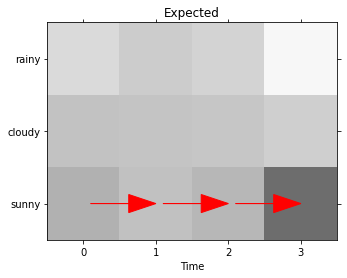

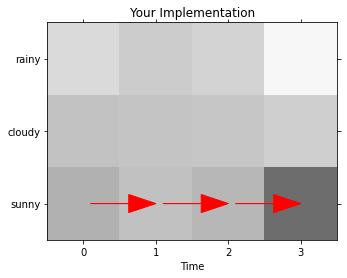

In [10]:
# sanity check using weather example

expected_f = np.array([
    [0.23985994, 0.34895595, 0.41118411],
    [0.3050589 , 0.3412514 , 0.35368971],
    [0.27514961, 0.33341264, 0.39143776],
    [0.06386911, 0.2900097 , 0.64612119]
])

actual_f = forward_backward(*get_weather_example(sequence=[2,1,0]))

# check shape
assert actual_f.shape == expected_f.shape,f'Shape mismatch, expected {expected_f.shape}, but got {actual_f.shape}.'

# Check well formedness
assert np.allclose(actual_f.sum(axis=1), np.ones((4,))), f'Proper probability distribution expected. (Entries sum to 1).'

# plot best path
plot_states(expected_f.argmax(axis=1), expected_f, title="Expected", state_names=['rainy', 'cloudy', 'sunny'])
plot_states(actual_f.argmax(axis=1), actual_f, title="Your Implementation",state_names=['rainy', 'cloudy', 'sunny'])

# check values
assert np.allclose(expected_f, actual_f), f'Result mismatch, expected \n{expected_f} \nbut got \n{actual_f}.'

### Decoding - Viterbi Algorithm

<div class="alert alert-warning">

Implement the Viterbi algorithm for decoding! (4 points)

</div>

`viterbi` takes two parameters:
 - `hmm` is a HMM object which holds $\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\Pi}$.
 - `observations` is a 1-D NumPy array of shape `(T,)` representing the observed sequence.
 
`viterbi` returns two objects:
1. a NumPy array of shape `(len(observations) + 1, hmm.num_states)`. The rows in this array hold a normalized version of the Viterbi message $\mathbf{v}^{(1:t)} = \text{max}_{s^{0}, ...,s^{t-1}} \; P(s^{(0)}, ..., s^{(t-1)}, S^{(t)}, \mathbf{o}^{(1:t)})$ for each time step $t$.<br>**Important:** Rescale these probabilities to avoid arithmetic underflow. Rescale each Viterbi message such that its values sum up to one.

2. a 1-D NumPy array of length `len(observations) + 1`. The values of this array represent the most probable path given the observations $\textit{arg max}_{\mathbf{S}^{0:T}} \; P(\mathbf{S}^{(0:T)} \mid \mathbf{o}^{(1:T)})$. Each state in the path is represented as an integer value.




*Hints*:
- initialize $\mathsf{v}^{(1:0)}$ with $\mathbf{\Pi}$.
- Use our modified formula to compute the next Viterbi message at time $t$ recursively given the previous one. $Z$ is the normalization constant, i.e. the sum over the values in the Viterbi message:
  $$\mathsf{v}_i^{(1:t+1)} = \text{max}_j\;\; \frac{1}{Z} \cdot \mathsf{v}_j^{(1:t)} a_{ji} b_i(o^{(t+1)}) $$
  Recheck the notes on the notation at the beginning of the notebook to understand the equation.

- For each state $s^{t}_i$, keep a back pointer to the best state that leads to it (starting at $t=1$): 
  $$\mathsf{bp}_i^{(1:t+1)} = \text{arg max}_j\;\; \mathsf{v}_j^{(1:t)} a_{ji} $$

- Using the back pointers $\mathsf{bp}^{(t)}$, you can trace the best path. Start with:
  $$s^{(T)*} = \text{arg max}_{i} \mathsf{v}_i^{(1:T)}$$

- `np.max` and `np.argmax` can be used to get the largest entry and the index of the largest element in a NumPy array, respectively.

- Almost all operations in the previous equations can be *vectorized* in NumPy, i.e., you will not need to iterate over $i$ or $j$.
- You can use a for-loop to iterate over the time steps.

In [11]:
def viterbi(hmm: HMM, observations: np.ndarray):
    """
    Computes the most probable state sequence for a given
    Hidden Markov Model and observations.
    
    :param hmm: HMM data structure
    :param observations: Numpy array containing the observations

    :return: Viterbi messages (each row represents a time step) and
             Numpy array of state IDs representing the most probable state sequence
    """
    v = np.empty((len(observations) + 1, hmm.num_states))
    bp = np.empty_like(v, dtype=int)
    p = np.empty((len(observations) + 1,), dtype=int)

    # YOUR CODE HERE
    v[0] = hmm.pi
    
    def rescale(arr):
        arr /= (arr.min() + 1e-10)
        return arr / arr.sum()

    for t in range(len(observations)):
        v[t + 1] = rescale((v[t].reshape(v[t].shape[0], 1) @ hmm.B[observations[t]].reshape(1, hmm.B.shape[1]) * hmm.A).max(0))
        bp[t + 1] = (hmm.A * v[t]).argmax(-1)
          
    p[-1] = v[-1].argmax()
    for t in reversed(range(1, len(observations) + 1)):
        p[t - 1] = bp[t, p[t]]

    return v, p

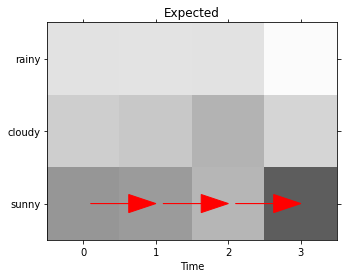

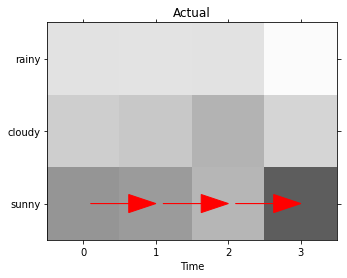

In [12]:
expected_v = np.array([
    [0.2       , 0.3       , 0.5       ],
    [0.19277108, 0.3253012 , 0.48192771],
    [0.19900498, 0.40298507, 0.39800995],
    [0.02967033, 0.26703297, 0.7032967 ]
])
expected_p = np.array([2, 2, 2, 2])

actual_v, actual_p = viterbi(*get_weather_example(sequence=[2,1,0]))

# check shape
assert actual_v.shape == expected_v.shape, f'Shape mismatch, expected {expected_v.shape}, but got {actual_v.shape}.'
assert actual_p.shape == expected_p.shape, f'Shape mismatch, expected {expected_p.shape}, but got {actual_p.shape}.'

# Check well formedness
assert np.allclose(actual_v.sum(axis=1), np.ones((4,))), f'Proper probability distribution expected. (Entries sum to 1).'

# plot best path
plot_states(expected_p, expected_v, title="Expected", state_names=['rainy', 'cloudy', 'sunny'])
plot_states(actual_p, actual_v, title="Actual",state_names=['rainy', 'cloudy', 'sunny'])

# check values
assert np.allclose(expected_v, actual_v), f'Result mismatch, expected \n{expected_v} \nbut got \n{actual_v}.'
assert np.allclose(expected_p, actual_p), f'Result mismatch, expected \n{expected_p} \nbut got \n{actual_p}.'

## Where is Santa? Find out using Hidden Markov Models.


Little Mary wakes up in the middle of the night of Christmas eve. She heard some noise.
Probably Santa Clause is coming with her presents! It’s dark, and she is not allowed to leave
her room, so she cannot check where Santa currently is. She can only listen carefully to infer
where he might be.

Santa can be either **absent**, on his **sleigh**, in the **chimney** or at the Christmas **tree**.To get to the Christmas tree, he has to go through the chimney because the doors are locked.
When he’s absent, there will be most probably silence; when he’s on the sleigh, there will be
probably some crackle or rumbling; in the chimney there will be most probably rumbling, and
when he’s at the Christmas tree putting the presents in place, there might be some crackle.

The following image shows the HMM modeling this situation, including transition probabilities.

<img style='width:100%;  max-width:400px;' src="hmm.svg">

The following tables give the observation probabilities:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;margin:0px auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-lqy6{text-align:right;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-baqh" colspan="2" rowspan="2"><nobr>$P( o \mid S )$</nobr></th>
    <th class="tg-baqh" colspan="4"><center>$S^{(t)}$</center></th>
  </tr>
  <tr>
    <td class="tg-baqh">a</td>
    <td class="tg-baqh">s</td>
    <td class="tg-baqh">c</td>
    <td class="tg-baqh">t</td>
  </tr>
  <tr>
    <td class="tg-baqh" rowspan="3">$o^{(t)}$<br></td>
    <td class="tg-lqy6">silence</td>
    <td class="tg-baqh">0.8</td>
    <td class="tg-baqh">0.1</td>
    <td class="tg-baqh">0.1</td>
    <td class="tg-baqh">0.1</td>
  </tr>
  <tr>
    <td class="tg-lqy6">rumbling</td>
    <td class="tg-baqh">0.1</td>
    <td class="tg-baqh">0.5</td>
    <td class="tg-baqh">0.8</td>
    <td class="tg-baqh">0.3</td>
  </tr>
  <tr>
    <td class="tg-lqy6">crackle</td>
    <td class="tg-baqh">0.1</td>
    <td class="tg-baqh">0.4</td>
    <td class="tg-baqh">0.1</td>
    <td class="tg-baqh">0.6</td>
  </tr>
</table>

The initial state distribution is given by the following table:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;margin:0px auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
</style>
<table class="tg">
  <tr>
    <th class="tg-s6z2" colspan="4"><center>$P(S^{(0)})$</center></th>
  </tr>
  <tr>
    <td class="tg-s6z2">a</td>
    <td class="tg-s6z2">s</td>
    <td class="tg-s6z2">c</td>
    <td class="tg-s6z2">t</td>
  </tr>
  <tr>
    <td class="tg-031e">0.8</td>
    <td class="tg-031e">0.1</td>
    <td class="tg-031e">0.1</td>
    <td class="tg-031e">0.0</td>
  </tr>
</table>

This is the corresponding state transition table: 

<table class="tg">
  <tr>
    <th class="tg-baqh" colspan="1" rowspan="2">$P( S^{(t+1)} \mid S^{(t)} )$</th>
    <th class="tg-baqh" colspan="1" rowspan="2"></th>
    <th class="tg-baqh" colspan="4"><center>$S^{(t)}$</center></th>
  </tr>
  <tr>
    <td class="tg-baqh">a</td>
    <td class="tg-baqh">s</td>
    <td class="tg-baqh">c</td>
    <td class="tg-baqh">t</td>
  </tr>
  <tr>
    <td class="tg-baqh" rowspan="4">$S^{(t+1)}$<br></td>
    <td class="tg-lqy6">a</td>
    <td class="tg-baqh">0.7</td>
    <td class="tg-baqh">0.3</td>
    <td class="tg-baqh">0.0</td>
    <td class="tg-baqh">0.0</td>
  </tr>
  <tr>
    <td class="tg-lqy6">s</td>
    <td class="tg-baqh">0.3</td>
    <td class="tg-baqh">0.4</td>
    <td class="tg-baqh">0.4</td>
    <td class="tg-baqh">0.0</td>
  </tr>
  <tr>
    <td class="tg-lqy6">c</td>
    <td class="tg-baqh">0.0</td>
    <td class="tg-baqh">0.3</td>
    <td class="tg-baqh">0.2</td>
    <td class="tg-baqh">0.3</td>
  </tr>
  <tr>
    <td class="tg-lqy6">t</td>
    <td class="tg-baqh">0.0</td>
    <td class="tg-baqh">0.0</td>
    <td class="tg-baqh">0.4</td>
    <td class="tg-baqh">0.7</td>
  </tr>  
</table>


Since Hidden Markov Models are not (yet) in the elementary school curriculum, Mary needs
your help to find out the whereabouts of Santa.
<div class="alert alert-info">
Nothing to do for you here; the follwong part is to check your implementation.
</div>

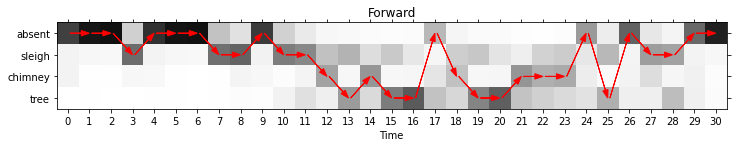

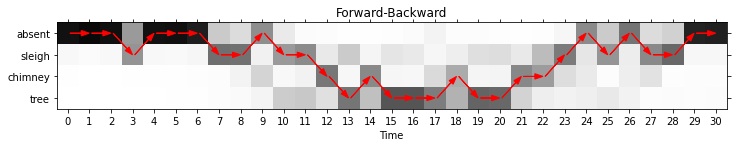

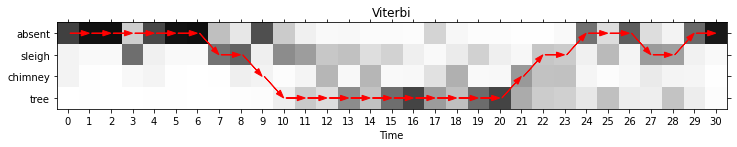

In [13]:
pi = np.array([0.8, 0.1, 0.1, 0.0])

A = np.array([[0.7, 0.3, 0.0, 0.0],
           [0.3, 0.4, 0.3, 0.0],
           [0.0, 0.4, 0.2, 0.4],
           [0.0, 0.0, 0.3, 0.7]])

B = np.array([[0.8, 0.1, 0.1, 0.1],
           [0.1, 0.5, 0.8, 0.3],
           [0.1, 0.4, 0.1, 0.6]])

model = HMM(pi, A, B)

# Mary's observations - 0 .. silence, 1 .. rumbling, 2 .. crackle
obs = np.array([0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 1, 2, 0, 0])

fwd = forward(model, obs)
f = fwd.argmax(1)

fwdbckwd = forward_backward(model, obs)
fb = fwdbckwd.argmax(1)

vt, vtp  = viterbi(model, obs)

true_fwd = np.array([[ 0.8       ,  0.1       ,  0.1       ,  0.        ],
    [ 0.92007797,  0.06237817,  0.00974659,  0.00779727],
    [ 0.94020048,  0.05406153,  0.00407881,  0.00165918],
    [ 0.28701312,  0.64972666,  0.05969411,  0.00356611]])
    
true_fwdbckwd = np.array([[  9.41085487e-01,   5.38720181e-02,   5.04249464e-03,   0.00000000e+00],
    [  9.65056826e-01,   3.34657970e-02,   1.03017901e-03,   4.47198412e-04],
    [  9.44024669e-01,   5.26712024e-02,   3.07328070e-03,   2.30848099e-04],
    [  4.86699963e-01,   5.07701911e-01,   5.41252605e-03,   1.85599925e-04]])
 
true_viterbi = np.array([[ 0.8       ,  0.1       ,  0.1       ,  0.        ],
    [ 0.93528184,  0.05010438,  0.00626305,  0.00835073],
    [ 0.94557515,  0.05065581,  0.0027137 ,  0.00105533],
    [ 0.30016956,  0.64322048,  0.05513318,  0.00147678]])

true_viterbi_path = np.array([0, 0, 0, 0, 0, 0, 0, 1])

assert np.allclose(fwd[:4], true_fwd), "Error in forward computation"
assert np.allclose(fwdbckwd[:4], true_fwdbckwd), "Error in forward-backward computation"
assert np.allclose(vt[:4], true_viterbi), "Error in viterbi computation"
assert (vtp[:8] == true_viterbi_path).all(), "Error in viterbit-path computation"

plot_states(f, fwd, 'Forward')
plot_states(fb, fwdbckwd, 'Forward-Backward')
plot_states(vtp, vt, 'Viterbi')

## Theory Questions
<div class="alert alert-warning">
Answer the following questions! (2 points each)
</div>

Inspect the paths (red arrows) computed with the forward, forward_backward, and Viterbi algorithm. Which path is a valid state sequence according to the state transition model?

Store True into the provided variable if the path is valid and False otherwise.

In [14]:
answers = {}
answers['forward'] = False
answers['forward_backward'] = True
answers['viterbi'] = True

# YOUR CODE HERE
forward = False
forward_backward = True
viterbi = True

In [15]:
assert answers['forward'] in [True, False]
assert answers['forward_backward'] in [True, False]
assert answers['viterbi'] in [True, False]


Which of the algorithms (forward, forward_backward, viterbi) yields a valid state sequence **in general**, i.e., for every possible HMM?

Store True into the provided variable if the algorithm **always** yields a valid state sequence and False otherwise.

In [16]:
answers = {}
answers['forward'] = False
answers['forward_backward'] = False
answers['viterbi'] = True

# YOUR CODE HERE
forward = False
forward_backward = False
viterbi = True

In [17]:
assert answers['forward'] in [True, False]
assert answers['forward_backward'] in [True, False]
assert answers['viterbi'] in [True, False]


Why do some of the algorithms yield a valid state sequence in general, and others do not. Explain briefly!

YOUR ANSWER HERE


The forward and forward-backward algorithms only give state probabilities (sequence of most probable states). It is not guaranteed that this is a valid path. The Viterbi algorithm uses a backpointer to determine which state most likely led to the one we are currently in.

### Bonus Problem:  Design a Hidden Markov Model

Design a model ($\mathbf{A}$, $\mathbf{B}$ and $\mathbf{\Pi}$) and an observation sequence for which only one of the algorithms returns a valid state sequence.

<div class="alert alert-warning">

Run the three algorithms with your custom HMM and plot the results with `plot_states`. Store the parameters of the Hidden Markov Model into the provided variables. (4 bonus points)

</div>

In [18]:
help(plot_states)

Help on function plot_states in module utils:

plot_states(path: numpy.ndarray, values: numpy.ndarray, title: str = None, state_names: list = ['absent', 'sleigh', 'chimney', 'tree']) -> None
    Plots the results of a algorithm. Black is 1, white is 0.
    
    :param path: List or array of state ids
    :param values: Detailed values returned by the algorithm (forward-variables, ...)
    :param title: Title of the plot
    :param state_names: Names of the states



In [22]:
# YOUR CODE HERE
pi = np.array([0.8, 0.1, 0.1])

A = np.array(
    [
        [0.7, 0.3, 0.0],
        [0.3, 0.4, 0.3],
        [0.0, 0.2, 0.8]
    ]
)

B = np.array(
    [
        [0.8, 0.1, 0.1],
        [0.1, 0.1, 0.8],
        [0.1, 0.8, 0.1]
    ]
)

model = HMM(pi, A, B)

obs = np.array([1, 2, 1])

fwd = forward(model, obs)
fwdbckwd = forward_backward(model, obs)
vt, vtp = viterbi(model, obs)

state_names = ['A', 'B', 'C']

plot_states(fwd.argmax(1), fwd, 'Forward', state_names)
plot_states(fwdbckwd.argmax(1), fwdbckwd, 'Forward-Backward', state_names)
plot_states(vtp, vt, 'Viterbi', state_names)

TypeError: 'bool' object is not callable

In [ ]:
assert pi is not None
assert A is not None
assert B is not None
assert obs is not None

model = HMM(pi, A, B)

fwd = forward(model, obs)
fwd_path = fwd.argmax(1)

fwdbckwd = forward_backward(model, obs)
fwdbckwd_path = fwdbckwd.argmax(1)

vt, vt_path  = viterbi(model, obs)

state_names = ['s%d' % (s + 1) for s in range(len(pi))]

plot_states(fwd_path, fwd, 'Forward', state_names=state_names)
plot_states(fwdbckwd_path, fwdbckwd, 'Forward-Backward', state_names=state_names)
plot_states(vt_path, vt, 'Viterbi', state_names=state_names)
